# Solution Workgroup 6 - R script
You have to replicate the results found in the paper of [Athey and Wager (2018) ](https://github.com/alexanderquispe/ECO224/blob/main/Report/week_7/causal_forest_Athey_Wagner_2019.pdf). I want to help you so I already found the steps you should follow to replicate this, check this [repo](https://github.com/grf-labs/grf/tree/master/experiments/acic18) and use the [code ](https://github.com/grf-labs/grf/tree/master/experiments/acic18) in there.
Please describe in detail the results you found in the next sections of the code:
1.  How the tree was built? 
2.  Estimate ATE
3.  Run best linear predictor analysis
4.  Look at school-wise heterogeneity
5.  Analysis ignoring clusters. How do the results change? 
6.  Analysis without fitting the propensity score 
7.  The code plot six plots in the **Make some plots** section, so explain what you find there. 
8. Visualize school-level covariates by treatment heterogeneity
9. CATE by school

## I. Estimating Treatment Effects with Causal Forests: An Application by Athey and Wager (2018)

The objective of this paper is to evaluate the impact of a nudge-like intervention designed to instill students with a growth mindset on student achievement using simulated data from a model fit from the National Study of Learning Mindsets. This paper aims to answer three questions:
 * Was the mindset intervention efective in improving student achievement?
 * Was the efect of the intervention moderated by school level achievement ($X_2$) or pre-existing mindset norms ($X_1$)?
 * Do other covariates moderate treatment efects?
 
However, there are 2 methodological challenges to take into account. First, althought is a randomized study, there seems to be some selection efects in the synthetic data. Because of this, the study will be analyzed as an observational rather than randomized study. Second, the students in this study all drawn from 76 randomly selected schools,thus, were not independently sampled. Since there seems to be considerable heterogeneity across schools because of this, we need make an analysis that robustly accounts for the sampling variability of potentially unexplained school-level in order to generalize outside our sample. 
 


In [1]:
#set seed to keep track of the same random numbers
set.seed(1)

In [2]:
# cleaning the environ
rm(list = ls())

# loading libraries
library(grf)
if(packageVersion("grf") < '0.10.2') {
  warning("This script requires grf 0.10.2 or higher")
}

library(sandwich)
library(lmtest)
library(ggplot2)

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric




In [3]:
# import data and chage formats
data.all = read.csv("synthetic_data.csv")

In [4]:
# a bit of data cleaning 
data.all$schoolid = factor(data.all$schoolid)

DF = data.all[,-1]
school.id = as.numeric(data.all$schoolid)

# setting a model
school.mat = model.matrix(~ schoolid + 0, data = data.all)
school.size = colSums(school.mat)

# It appears that school ID does not affect pscore. So ignore it in modeling, 
# and just treat it as source of per-cluster error.
w.lm = glm(Z ~ ., data = data.all[,-3], family = binomial)
summary(w.lm)


W = DF$Z
Y = DF$Y
X.raw = DF[,-(1:2)]

C1.exp = model.matrix(~ factor(X.raw$C1) + 0)
XC.exp = model.matrix(~ factor(X.raw$XC) + 0)

X = cbind(X.raw[,-which(names(X.raw) %in% c("C1", "XC"))], C1.exp, XC.exp)


Call:
glm(formula = Z ~ ., family = binomial, data = data.all[, -3])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.2079  -0.9088  -0.8297   1.4176   1.9556  

Coefficients: (6 not defined because of singularities)
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.9524636  0.2845173  -3.348 0.000815 ***
schoolid2    0.0697302  0.2766287   0.252 0.800986    
schoolid3    0.0382080  0.2911323   0.131 0.895586    
schoolid4    0.1761334  0.2784711   0.633 0.527059    
schoolid5   -0.0033389  0.2950180  -0.011 0.990970    
schoolid6    0.0583548  0.3067481   0.190 0.849124    
schoolid7   -0.1313759  0.3188190  -0.412 0.680288    
schoolid8    0.1233661  0.3023736   0.408 0.683279    
schoolid9   -0.1955428  0.3073344  -0.636 0.524611    
schoolid10  -0.1892794  0.2968750  -0.638 0.523752    
schoolid11  -0.2224060  0.5461005  -0.407 0.683816    
schoolid12  -0.3312420  0.5414374  -0.612 0.540682    
schoolid13  -0.0408540  0.3989507  -0.102 0.9

### 1. How the tree was built?

In [5]:
# Random forest with all the features
Y.forest = regression_forest(X, Y, clusters = school.id, equalize.cluster.weights = TRUE)
Y.hat = predict(Y.forest)$predictions
W.forest = regression_forest(X, W, clusters = school.id, equalize.cluster.weights = TRUE)
W.hat = predict(W.forest)$predictions

With this predictions, the estimate a pilot causal forest on all the features.

Now, we estimate the causal forest.

In [6]:
# a random forest, consideding the clusters,  
cf.raw = causal_forest(X, Y, W,
                       Y.hat = Y.hat, W.hat = W.hat,
                       clusters = school.id,
                       equalize.cluster.weights = TRUE)
varimp = variable_importance(cf.raw)
selected.idx = which(varimp > mean(varimp))

In [7]:
cf = causal_forest(X[,selected.idx], Y, W,
                   Y.hat = Y.hat, W.hat = W.hat,
                   clusters = school.id,
                   equalize.cluster.weights = TRUE,
                   tune.parameters = "all")
tau.hat = predict(cf)$predictions

### 2. Estimate ATE

In [8]:
ATE = average_treatment_effect(cf)
paste("95% CI for the ATE:", round(ATE[1], 3),
      "+/-", round(qnorm(0.975) * ATE[2], 3))

[1] "95% CI for the ATE: 0.247 +/- 0.039"

With the tuned parameters, we estimate the average treatment effect (ATE). The results show it is 0.248 and its  confidence interval goes from 0.0209 to 0.287 (+/-0.039) at a 95/% confidence level. It means that the effect of the intervetion related to the growth mindset had a positive and significant impact on the measure of achievement of the students on average. 

### 3. Run the best linear predictor analysis

The best linear predictor indicates whether or not treatment heterogeneity estimates are well-calibrated. Since the estimator is close to $1$ and significant, we can assume the causal forest was successful in finding heterogeneity.

In [9]:
# Run best linear predictor analysis
test_calibration(cf)

# Compare regions with high and low estimated CATEs
high_effect = tau.hat > median(tau.hat)
ate.high = average_treatment_effect(cf, subset = high_effect)
ate.low = average_treatment_effect(cf, subset = !high_effect)
paste("95% CI for difference in ATE:",
      round(ate.high[1] - ate.low[1], 3), "+/-",
      round(qnorm(0.975) * sqrt(ate.high[2]^2 + ate.low[2]^2), 3))


Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value Pr(>t)    
mean.forest.prediction         1.006886   0.083618 12.0415 <2e-16 ***
differential.forest.prediction 0.292474   0.655626  0.4461 0.3278    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


[1] "95% CI for difference in ATE: 0.054 +/- 0.07"

It finds that if we insists in cluster-robust inference, there's almost no treatment heterogenity present and thus that the causal forest couldn't identify subgroups with effects at stand. 

In [10]:
# formal test for X1 and X2
dr.score = tau.hat + W / cf$W.hat *
  (Y - cf$Y.hat - (1 - cf$W.hat) * tau.hat) -
  (1 - W) / (1 - cf$W.hat) * (Y - cf$Y.hat + cf$W.hat * tau.hat)
school.score = t(school.mat) %*% dr.score / school.size

school.X1 = t(school.mat) %*% X$X1 / school.size
high.X1 = school.X1 > median(school.X1)
t.test(school.score[high.X1], school.score[!high.X1])

school.X2 = (t(school.mat) %*% X$X2) / school.size
high.X2 = school.X2 > median(school.X2)
t.test(school.score[high.X2], school.score[!high.X2])

school.X2.levels = cut(school.X2,
  breaks = c(-Inf, quantile(school.X2, c(1/3, 2/3)), Inf))
summary(aov(school.score ~ school.X2.levels))


	Welch Two Sample t-test

data:  school.score[high.X1] and school.score[!high.X1]
t = -3.0755, df = 71.824, p-value = 0.002972
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.19359639 -0.04132175
sample estimates:
mean of x mean of y 
0.1884369 0.3058960 



	Welch Two Sample t-test

data:  school.score[high.X2] and school.score[!high.X2]
t = 0.99875, df = 72.391, p-value = 0.3212
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.04006824  0.12054510
sample estimates:
mean of x mean of y 
0.2672857 0.2270472 


                 Df Sum Sq Mean Sq F value Pr(>F)
school.X2.levels  2 0.0826 0.04128   1.351  0.265
Residuals        73 2.2304 0.03055               

### 4. Look at school-wise heterogeneity

To identify heteregenous effects, we fit models using only school-level covariates. It seems to be presented on the next graphs, where the distribution of the school treatment effects and the student expectation success propensity score are shown.

null device 
          1

[1] "0.247 +/- 0.039"


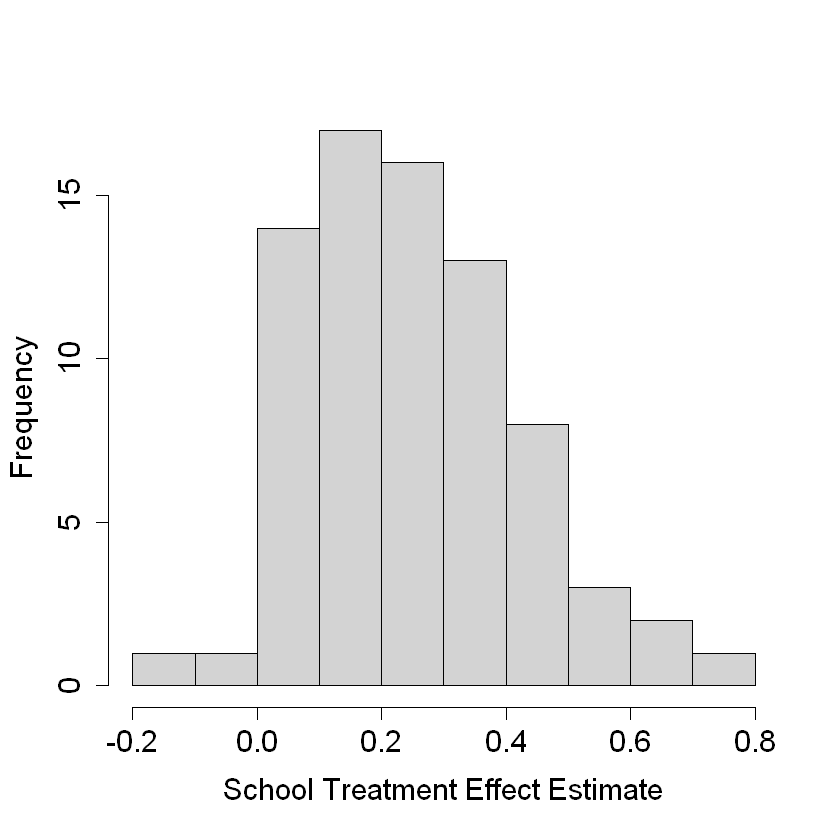

In [11]:
# Look at school-wise heterogeneity
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(school.score, xlab = "School Treatment Effect Estimate", main = "")
dev.off()

# Re-check ATE... sanity check only
ate.hat = mean(school.score)
se.hat = sqrt(var(school.score) / length(school.score - 1))
print(paste(round(ate.hat, 3), "+/-", round(1.96 * se.hat, 3)))

null device 
          1

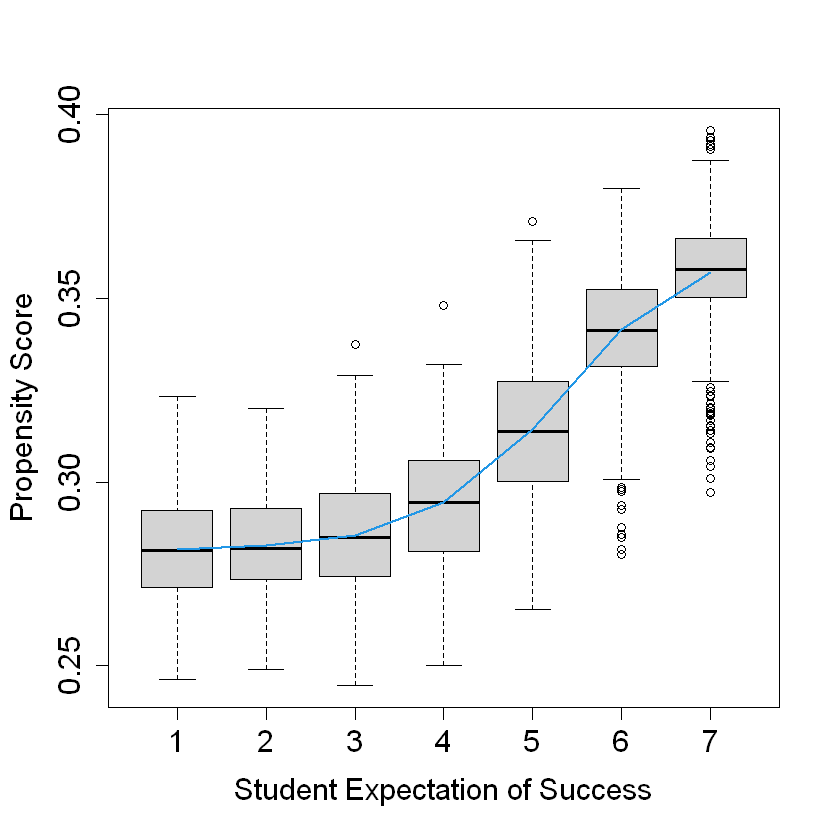

In [12]:
# Look at variation in propensity scores
DF = X
DF$W.hat = cf$W.hat

#pdf("pscore.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
boxplot(W.hat ~ S3, data = DF, ylab = "Propensity Score", xlab = "Student Expectation of Success")
lines(smooth.spline(X$S3, cf$W.hat), lwd = 2, col = 4)
dev.off()

We run an random forest and an OLS of the prediction made before and this covariates to find out whther this effects remain in a simple estimation using only the school-level covariates.

In [13]:
# Train forest on school-wise DR scores
school.X = (t(school.mat) %*% as.matrix(X[,c(4:8, 25:28)])) / school.size
school.X = data.frame(school.X)
colnames(school.X) = c("X1", "X2", "X3", "X4", "X5",
                    "XC.1", "XC.2", "XC.3", "XC.4")

dr.score = tau.hat + W / cf$W.hat * (Y - cf$Y.hat - (1 - cf$W.hat) * tau.hat) -
  (1 - W) / (1 - cf$W.hat) * (Y - cf$Y.hat + cf$W.hat * tau.hat)
school.score = t(school.mat) %*% dr.score / school.size

school.forest = regression_forest(school.X, school.score)
school.pred = predict(school.forest)$predictions
test_calibration(school.forest)


Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value Pr(>t)    
mean.forest.prediction         1.005054   0.082992 12.1102 <2e-16 ***
differential.forest.prediction 0.591786   0.667596  0.8864 0.1891    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


In [14]:
# Alternative OLS analysis
school.DF = data.frame(school.X, school.score=school.score)
coeftest(lm(school.score ~ ., data = school.DF), vcov = vcovHC)


t test of coefficients:

              Estimate Std. Error t value Pr(>|t|)   
(Intercept)  0.2433855  0.0771666  3.1540 0.002424 **
X1          -0.0495439  0.0291700 -1.6985 0.094132 . 
X2           0.0127040  0.0337703  0.3762 0.707984   
X3           0.0093747  0.0264377  0.3546 0.724023   
X4           0.0222932  0.0256041  0.8707 0.387080   
X5          -0.0342604  0.0268506 -1.2760 0.206440   
XC.1        -0.0030273  0.0930189 -0.0325 0.974136   
XC.2         0.0839073  0.1051560  0.7979 0.427772   
XC.3        -0.1351282  0.0878695 -1.5378 0.128871   
XC.4         0.0398784  0.0820527  0.4860 0.628570   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Here we can see there's seems to be a correlation between the distribution of the propensity score and the student expectation of sucess: more expectation leed to a distribution of the propensity score that holds higher values in comparison to the level of expectations.

### 5. Analysis ignoring clusters. How do the results change?

When ignoring clusters, the ATE is slightly higher at $0.252$, with a smaller confidence interval (roughly half of the previous CI) of $0.022$.

In [15]:
# Analysis ignoring clusters
cf.noclust = causal_forest(X[,selected.idx], Y, W,
                           Y.hat = Y.hat, W.hat = W.hat,
                           tune.parameters = "all")

ATE.noclust = average_treatment_effect(cf.noclust)
paste("95% CI for the ATE:", round(ATE.noclust[1], 3),
      "+/-", round(qnorm(0.975) * ATE.noclust[2], 3))

test_calibration(cf.noclust)

[1] "95% CI for the ATE: 0.252 +/- 0.022"


Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value    Pr(>t)    
mean.forest.prediction         1.015464   0.045321 22.4063 < 2.2e-16 ***
differential.forest.prediction 0.433940   0.109583  3.9599 3.774e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


However, as we can see in the following graph, it seems that is more disperse that the ATE with clustering.

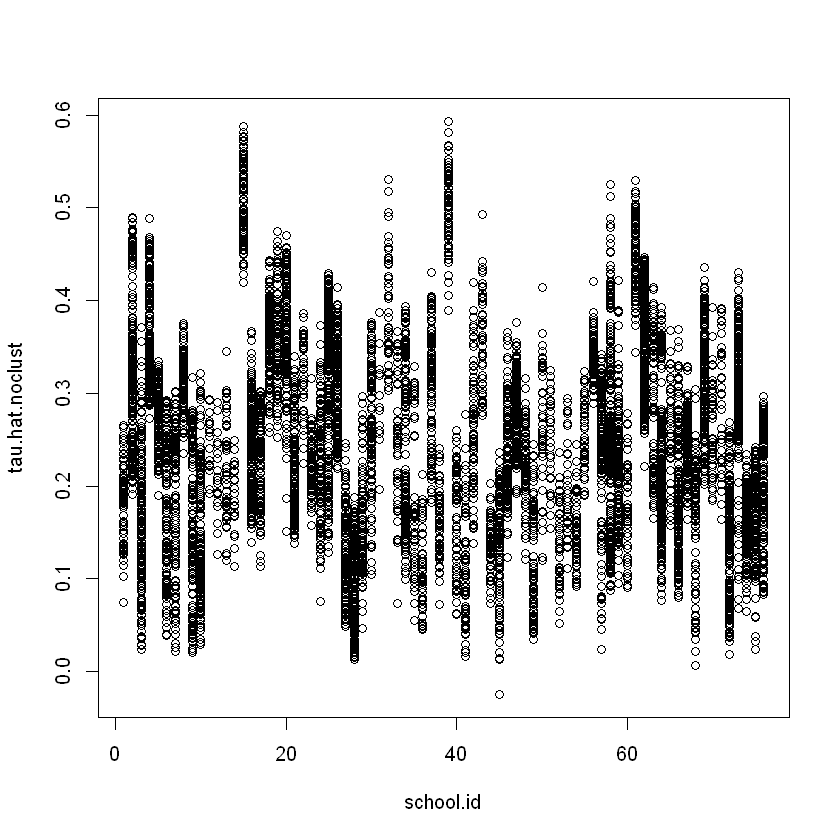

In [16]:
tau.hat.noclust = predict(cf.noclust)$predict
plot(school.id, tau.hat.noclust)

We take this issue into account by trying a 5-fold version where the estimation folds are "clustered".

In [17]:
nfold = 5
school.levels = unique(school.id)
cluster.folds = sample.int(nfold, length(school.levels), replace = TRUE)

tau.hat.crossfold = rep(NA, length(Y))
for (foldid in 1:nfold) {
  print(foldid)
  infold = school.id %in% school.levels[cluster.folds == foldid]
  cf.fold = causal_forest(X[!infold, selected.idx], Y[!infold], W[!infold],
                          Y.hat = Y.hat[!infold], W.hat = W.hat[!infold],
                          tune.parameters = "all")
  pred.fold = predict(cf.fold, X[infold, selected.idx])$predictions
  tau.hat.crossfold[infold] = pred.fold
}

cf.noclust.cpy = cf.noclust
cf.noclust.cpy$predictions = tau.hat.crossfold
cf.noclust.cpy$clusters = school.id
test_calibration(cf.noclust.cpy)

Rloss = mean(((Y - Y.hat) - tau.hat * (W - W.hat))^2)
Rloss.noclust = mean(((Y - Y.hat) - tau.hat.noclust * (W - W.hat))^2)
Rloss.crossfold = mean(((Y - Y.hat) - tau.hat.crossfold * (W - W.hat))^2)

c(Rloss.noclust - Rloss, Rloss.crossfold - Rloss)

summary(aov(dr.score ~ factor(school.id)))

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5



Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value Pr(>t)    
mean.forest.prediction         1.002280   0.066111 15.1606 <2e-16 ***
differential.forest.prediction 0.226658   0.226340  1.0014 0.1583    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


[1] 0.0004379946 0.0005338118

                     Df Sum Sq Mean Sq F value   Pr(>F)    
factor(school.id)    75    200   2.673   1.989 8.85e-07 ***
Residuals         10315  13861   1.344                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

### 6. Analysis without fitting the propensity score

We see that propensity score is not as important to the results found as clsutering was since it appers to be that the ATE found ($0.254$) is very much similar to the one found using orthogalization.

[1] "95% CI for the ATE: 0.254 +/- 0.039"

null device 
          1

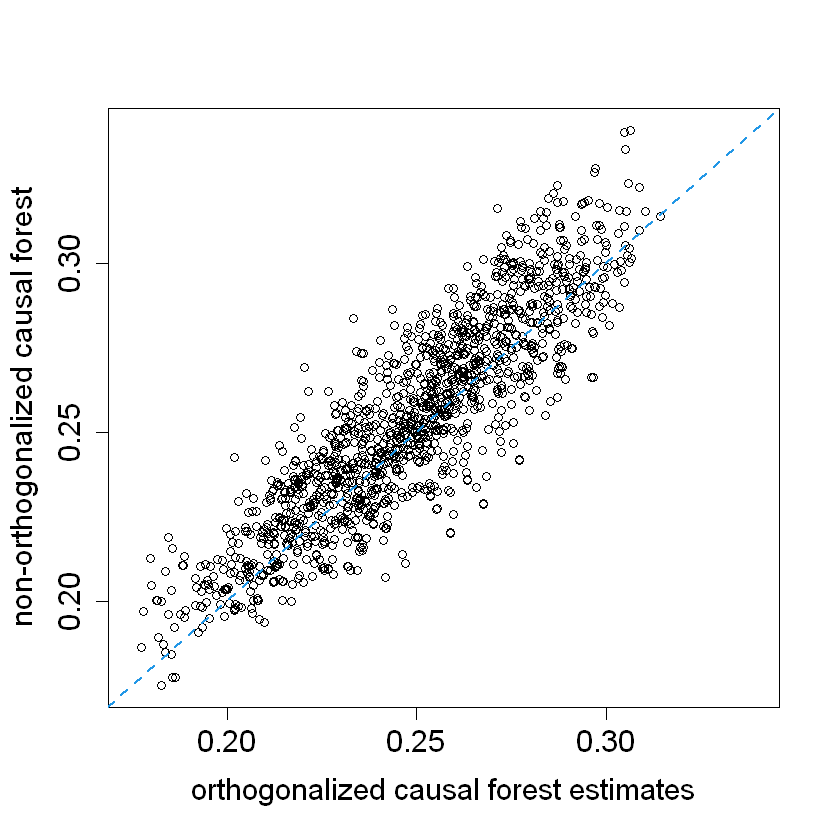

In [18]:
# Analaysis without fitting the propensity score
cf.noprop = causal_forest(X[,selected.idx], Y, W,
                          Y.hat = Y.hat, W.hat = mean(W),
                          tune.parameters = "all",
                          equalize.cluster.weights = TRUE,
                          clusters = school.id)
tau.hat.noprop = predict(cf.noprop)$predictions

ATE.noprop = average_treatment_effect(cf.noprop)
paste("95% CI for the ATE:", round(ATE.noprop[1], 3),
      "+/-", round(qnorm(0.975) * ATE.noprop[2], 3))

#pdf("tauhat_noprop.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
plot(tau.hat, tau.hat.noprop,
     xlim = range(tau.hat, tau.hat.noprop),
     ylim = range(tau.hat, tau.hat.noprop),
     xlab = "orthogonalized causal forest estimates",
     ylab = "non-orthogonalized causal forest")
abline(0, 1, lwd = 2, lty = 2, col = 4)
par = pardef
dev.off()

In [19]:
# Experiment with no orthogonalization
n.synth = 1000
p.synth = 10
X.synth = matrix(rnorm(n.synth * p.synth), n.synth, p.synth)
W.synth = rbinom(n.synth, 1, 1 / (1 + exp(-X.synth[,1])))
Y.synth = 2 * rowMeans(X.synth[,1:6]) + rnorm(n.synth)

Y.forest.synth = regression_forest(X.synth, Y.synth)
Y.hat.synth = predict(Y.forest.synth)$predictions
W.forest.synth = regression_forest(X.synth, W.synth)
W.hat.synth = predict(W.forest.synth)$predictions

cf.synth = causal_forest(X.synth, Y.synth, W.synth,
                         Y.hat = Y.hat.synth, W.hat = W.hat.synth)
ATE.synth = average_treatment_effect(cf.synth)
paste("95% CI for the ATE:", round(ATE.synth[1], 3),
      "+/-", round(qnorm(0.975) * ATE.synth[2], 3))

cf.synth.noprop = causal_forest(X.synth, Y.synth, W.synth,
                                Y.hat = Y.hat.synth, W.hat = mean(W.synth))
ATE.synth.noprop = average_treatment_effect(cf.synth.noprop)
paste("95% CI for the ATE:", round(ATE.synth.noprop[1], 3),
      "+/-", round(qnorm(0.975) * ATE.synth.noprop[2], 3))

[1] "95% CI for the ATE: -0.055 +/- 0.145"

[1] "95% CI for the ATE: 0.055 +/- 0.143"

### Some plots

null device 
          1

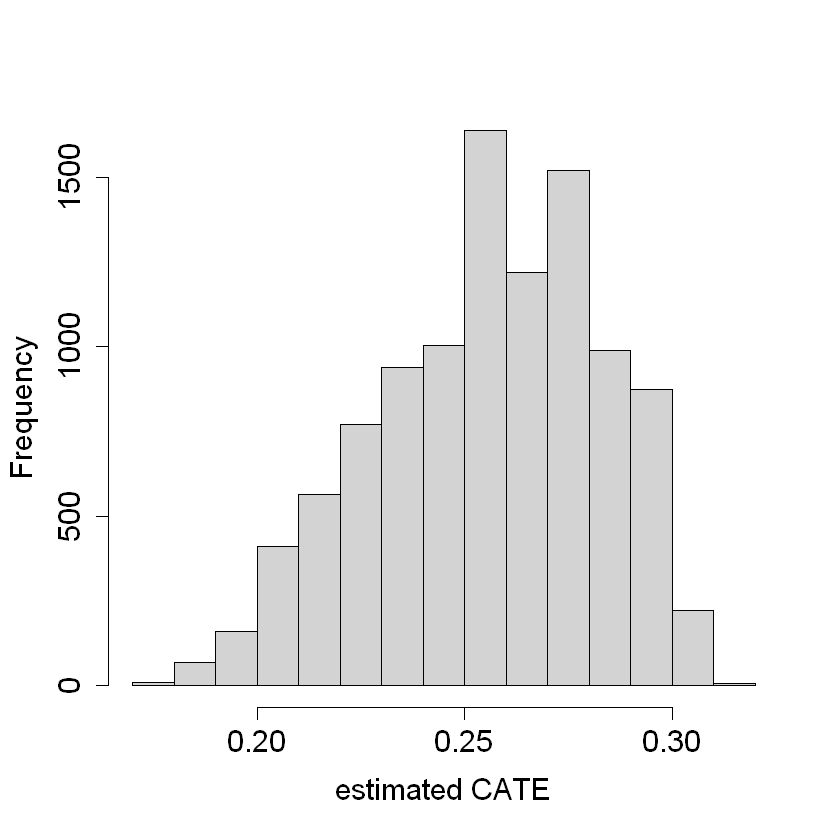

In [20]:
#pdf("tauhat_hist.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(tau.hat, xlab = "estimated CATE", main = "")
dev.off()

Here is the distribution of the estimated CATE using clustering and orthogonzization. As we can see, the distribution is not very disperse (concentrates basically on 0.2 y 0.3) and it's no too large considering this values. This make us question whether there exist significant heteregenous effects, and, as seen before, there seems no to be heteregenous effects. 

null device 
          1

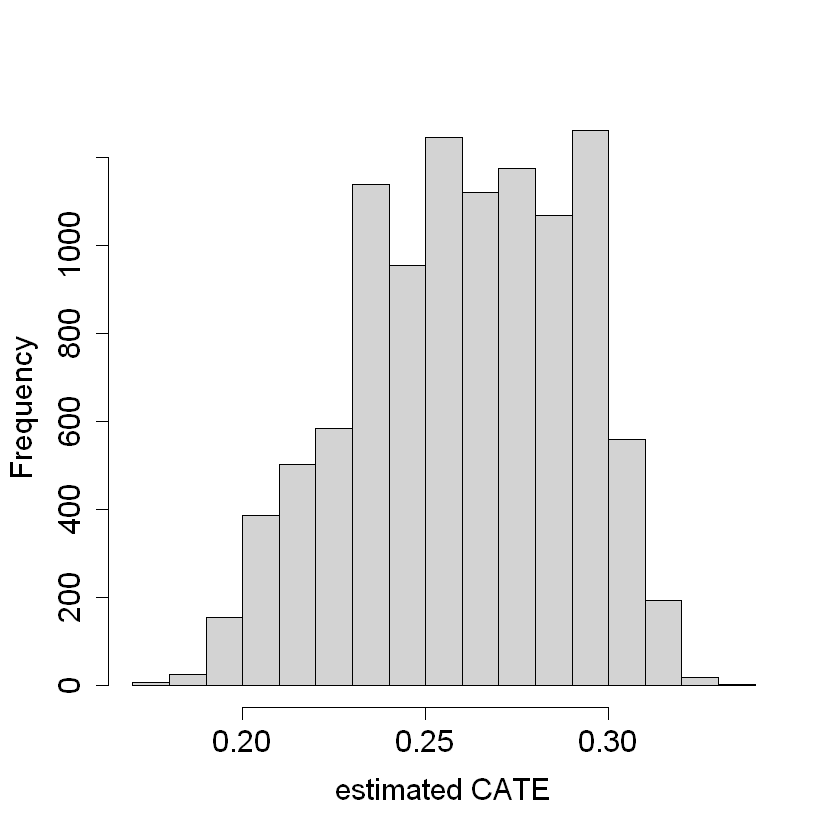

In [21]:
#pdf("tauhat_hist_noprop.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(tau.hat.noprop, xlab = "estimated CATE", main = "")
dev.off()

When we don't consider the propensity score that helps us to regulate for the large of the school, we found that this effect is very similar to the one found when we take into account this. As we can see, this ATE is concentrated between the same values as the previous one (0.2 and 0.3), holding the same hypothesis as before: there's not enough evidence to prove heterogenous effects between schools. 

null device 
          1

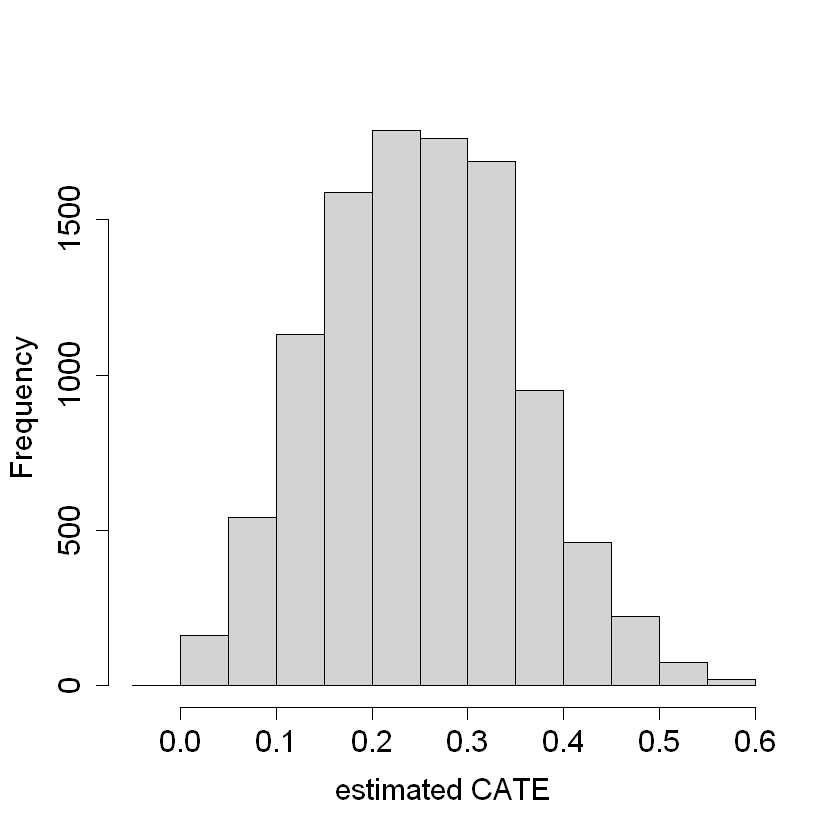

In [22]:
#pdf("tauhat_hist_noclust.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(tau.hat.noclust, xlab = "estimated CATE", main = "")
dev.off()

This result is very different when we ignore the clusters. As found before. We find that the distribution of the ATE seems to hold higher values than when considering clustering, but at the same time the distribution is more disperse since now is between 0.0 a 0.6 (almost the triple size of the range!). However, as hold before, this a naive approach since it ignores the possible correlations of the student's errors that attend the same school.

null device 
          1

null device 
          1

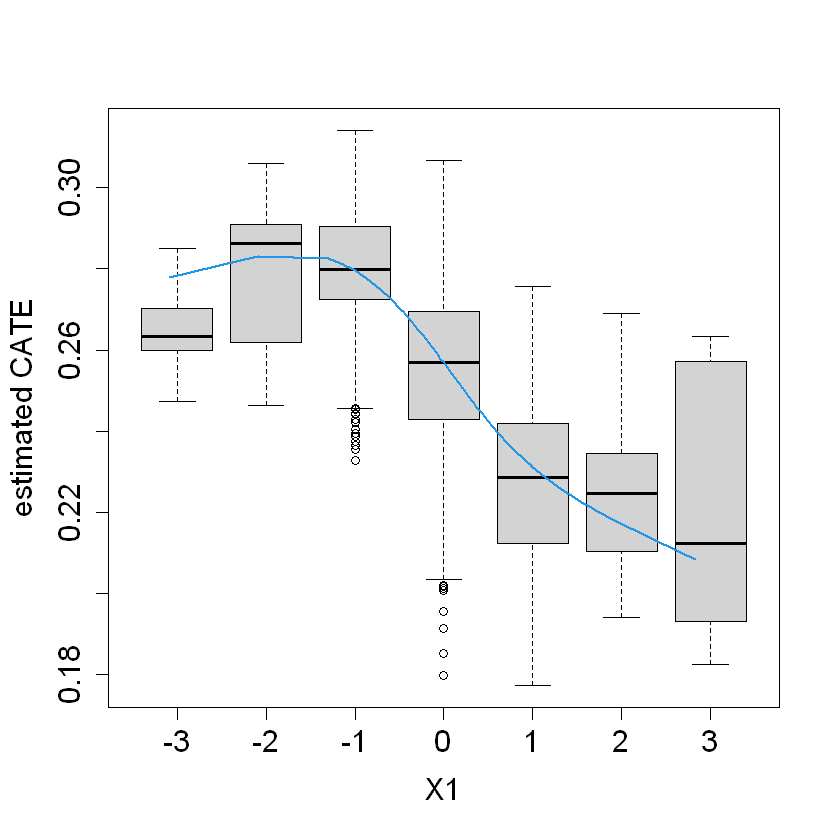

In [23]:
#pdf("tauhat_vs_X1.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
boxplot(tau.hat ~ round(X$X1), xlab = "X1", ylab = "estimated CATE")
lines(smooth.spline(4 + X[,"X1"], tau.hat, df = 4), lwd = 2, col = 4)
dev.off()

#pdf("tauhat_vs_X2.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
boxplot(tau.hat ~ round(X$X2), xlab = "X2", ylab = "estimated CATE")
lines(smooth.spline(4 + X[,"X2"], tau.hat, df = 4), lwd = 2, col = 4)
dev.off()

school.avg.tauhat = t(school.mat) %*% tau.hat / school.size

It seems to be a negative relation between school-level and the CATE. It explains why $X_1$ is the best predictor of $Y$. However, when controlling by other variables, there's no enough evidence that school-level is enough to prove heterogenity .

null device 
          1

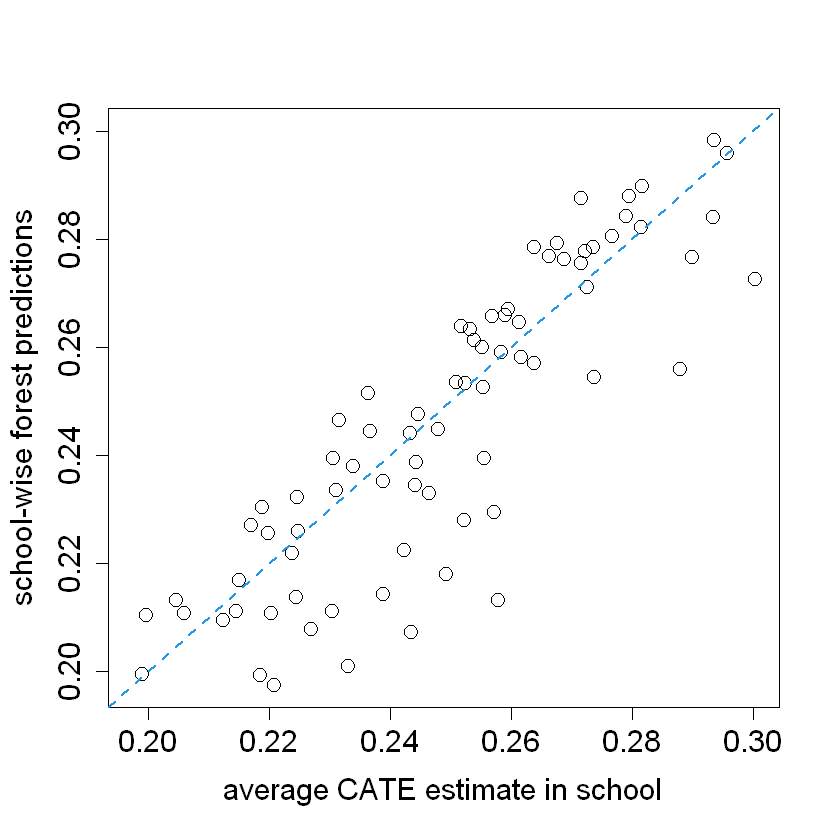

In [24]:
#pdf("school_avg.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
plot(school.avg.tauhat, school.pred, cex = 1.5,
     xlim = range(school.avg.tauhat, school.pred),
     ylim = range(school.avg.tauhat, school.pred),
     xlab = "average CATE estimate in school",
     ylab = "school-wise forest predictions")
abline(0, 1, lwd = 2, lty = 2, col = 4)
par = pardef
dev.off()

This graphs shows us the positive relation between the school-level predictions using school-level covariates and the average CATE estimates in school. This means that higher predictions of the measures of achievement are found when the average CATE estimate in a school is also higher. 

### 8. Visualize school-level covariates by treatment heterogeneity

[1] 0.2105263

[1] 0.5384615

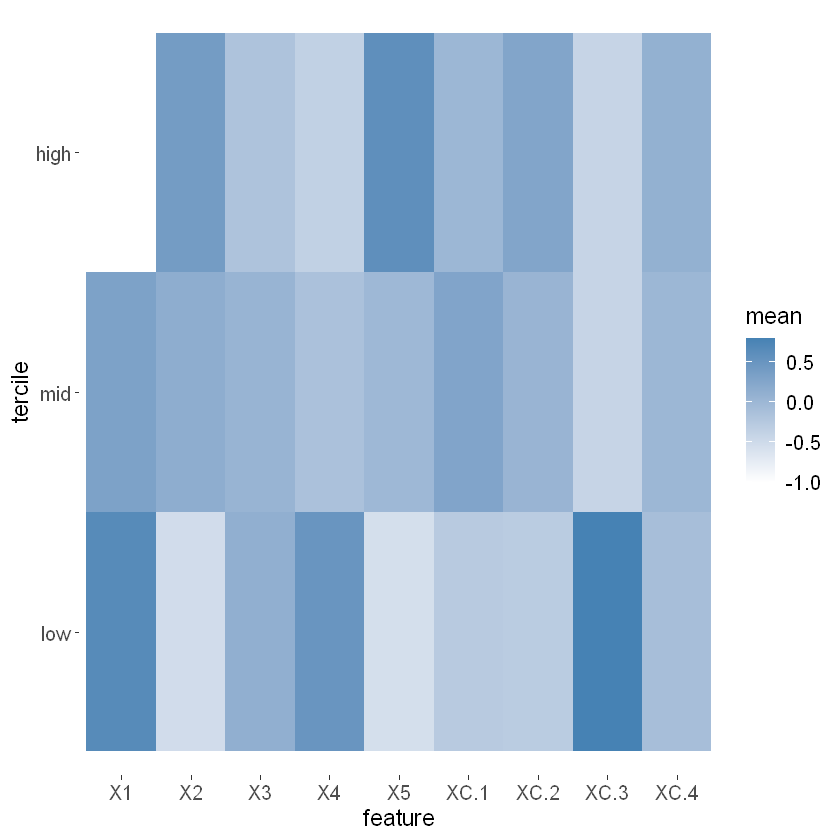

In [25]:
# Visualize school-level covariates by treatment heterogeneity
school.X.std = scale(school.X)
school.tercile = cut(school.pred,
                     breaks = c(-Inf, quantile(school.pred, c(1/3, 2/3)), Inf))
school.tercile.mat = model.matrix(~ school.tercile + 0)
school.means = diag(1 / colSums(school.tercile.mat)) %*% t(school.tercile.mat) %*% as.matrix(school.X.std)

MM = max(abs(school.means))
HC = heat.colors(21)
school.col = apply(school.means, 1:2, function(aa) HC[1 + round(20 * (0.5 + aa))])

DF.plot = data.frame(tercile=rep(factor(1:3, labels=c("low", "mid", "high")), 9), mean=as.numeric(school.means),
                     feature = factor(rbind(colnames(school.X), colnames(school.X), colnames(school.X))))

ggplot(data = DF.plot, aes(x = feature, y = tercile, fill = mean)) +
    geom_tile() + scale_fill_gradient(low = "white", high = "steelblue") +
    theme(axis.text = element_text(size=12), axis.title = element_text(size=14),
          legend.title = element_text(size=14), legend.text = element_text(size=12)) +
    theme(panel.background = element_blank())
#ggsave("tercile_plot.pdf", width = 8, height = 4.5, dpi = 120)

mean(school.X$XC.3)
mean(school.X$XC.3[as.numeric(school.tercile) == 1])

                   

This graph show us the difference between the mean of the CATE for each school-level covariate considered in the school-wise estimation. We can see that there is not much hetereginty between the means in all covariates but the $X_1$, where the difference between the low and high group of CATEs. This reminds us that even if it seem to be variability in the effects when we divide by this covariate, there's not enough evidence that controling with the other covariates this effect will remain even when analysing the data at school-level.

### 9. CATE by school

null device 
          1

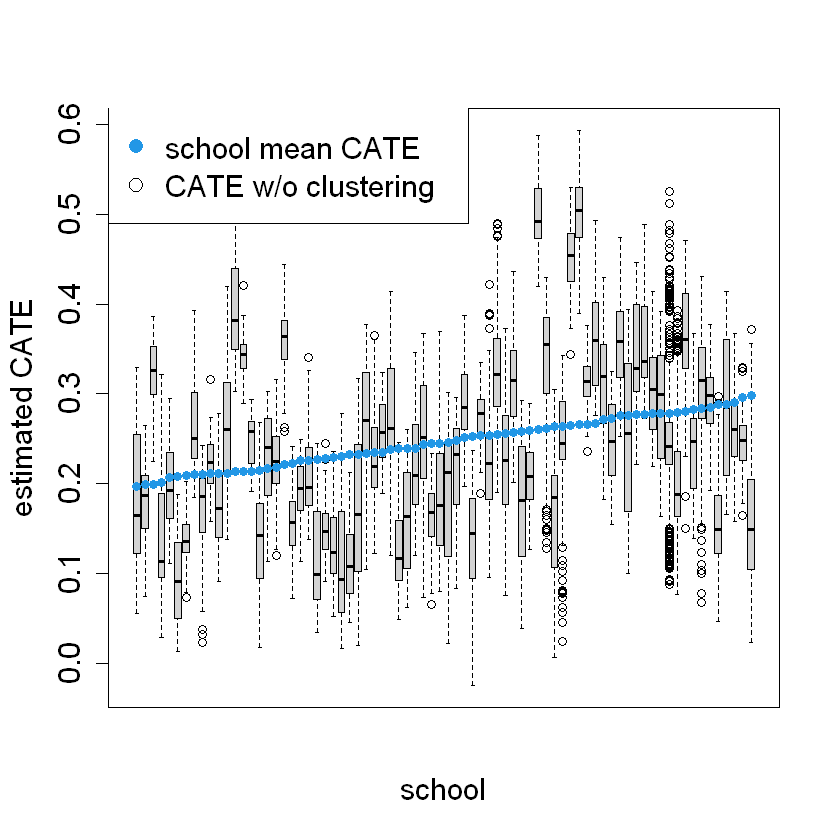

In [26]:
# CATE by school
ord = order(order(school.pred))
school.sort = ord[school.id]

#pdf("school_boxplot.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
boxplot(tau.hat.noclust ~ school.sort, xaxt = "n",
        xlab = "school", ylab = "estimated CATE")
points(1:76, sort(school.pred), col = 4, pch = 16)
legend("topleft", c("school mean CATE", "CATE w/o clustering"), pch = c(16, 1), col = c(4, 1), cex = 1.5)
par = pardef
dev.off()

This graph compares per-student predictions from a non-cluster-robust causal forest to per-school mean treatment effect predictions from a forest trained on per-school responses that takes clustering into account. As seen before. We can see that CATE found in when ignoring clusters is higher and more disperse by school than when considering clusters. 

## II. Debiased Machine Learning (DML) applied to the Convergence Hypothesis


## Data

$Y_{j,t}$ is growth rate in country $j$ at time $t$, $D_{j, t-1}$ is  initial wealth in country $j$ at time $t-1$ and $Z_{j,t}$ is a set of demographic and economic characteristics of country $j$ at time $t$.

In [27]:
library(hdm)
library(xtable)

In [28]:
# Export data to read in python
GrowthData <- GrowthData
save(GrowthData, file = "../GrowthData.RData")

In [29]:
library(hdm)
data <- GrowthData
attach(data)
names(data)

[1] "Outcome"   "intercept" "gdpsh465"  "bmp1l"     "freeop"    "freetar"  
 [7] "h65"       "hm65"      "hf65"      "p65"       "pm65"      "pf65"     
[13] "s65"       "sm65"      "sf65"      "fert65"    "mort65"    "lifee065" 
[19] "gpop1"     "fert1"     "mort1"     "invsh41"   "geetot1"   "geerec1"  
[25] "gde1"      "govwb1"    "govsh41"   "gvxdxe41"  "high65"    "highm65"  
[31] "highf65"   "highc65"   "highcm65"  "highcf65"  "human65"   "humanm65" 
[37] "humanf65"  "hyr65"     "hyrm65"    "hyrf65"    "no65"      "nom65"    
[43] "nof65"     "pinstab1"  "pop65"     "worker65"  "pop1565"   "pop6565"  
[49] "sec65"     "secm65"    "secf65"    "secc65"    "seccm65"   "seccf65"  
[55] "syr65"     "syrm65"    "syrf65"    "teapri65"  "teasec65"  "ex1"      
[61] "im1"       "xr65"      "tot1"

In [30]:
head(data)

,Outcome,intercept,gdpsh465,bmp1l,freeop,freetar,h65,hm65,hf65,p65,...,seccf65,syr65,syrm65,syrf65,teapri65,teasec65,ex1,im1,xr65,tot1
,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.02433575,1,6.591674,0.2837,0.153491,0.043888,0.007,0.013,0.001,0.29,...,0.04,0.033,0.057,0.010,47.6,17.3,0.0729,0.0667,0.348,-0.014727
2,0.10047257,1,6.829794,0.6141,0.313509,0.061827,0.019,0.032,0.007,0.91,...,0.64,0.173,0.274,0.067,57.1,18.0,0.0940,0.1438,0.525,0.005750
3,0.06705148,1,8.895082,0.0000,0.204244,0.009186,0.260,0.325,0.201,1.00,...,18.14,2.573,2.478,2.667,26.5,20.7,0.1741,0.1750,1.082,-0.010040
4,0.06408917,1,7.565275,0.1997,0.248714,0.036270,0.061,0.070,0.051,1.00,...,2.63,0.438,0.453,0.424,27.8,22.7,0.1265,0.1496,6.625,-0.002195
5,0.02792955,1,7.162397,0.1740,0.299252,0.037367,0.017,0.027,0.007,0.82,...,2.11,0.257,0.287,0.229,34.5,17.6,0.1211,0.1308,2.500,0.003283
6,0.04640744,1,7.218910,0.0000,0.258865,0.020880,0.023,0.038,0.006,0.50,...,1.46,0.160,0.174,0.146,34.3,8.1,0.0634,0.0762,1.000,-0.001747


### Preprocessing

Now, we can construct the treatment variable, the outcome variable and the matrix $Z$ that includes the control variables.

In [31]:
# Treatment Variable
D =  data.frame(data$gdpsh465)
# Outcome Variable
Y = data.frame(data$Outcome)

# Construct matrix Z
x_1 = data[4:63]
x_2 = data[2]
X <- c(x_2,x_1)
Z  = data.frame(X)

In [32]:
dim(Z)

[1] 90 61

We have in total 61 control variables.

In [33]:
library(lfe)

Loading required package: Matrix


Attaching package: 'lfe'


The following object is masked from 'package:lmtest':

    waldtest




### 1. OLS

After preprocessing the data, we first look at simple regression of $Y_{j,t}$ on $D_{j,t-1}$ without controls as a baseline model.

In [34]:
baseline.ols <- felm(Outcome ~ gdpsh465,data=data) 
est_baseline <- summary(baseline.ols)$coef[2,]
confint(baseline.ols)[2,]
est_baseline

2.5 %      97.5 % 
-0.01081013  0.01344355

Estimate  Std. Error     t value    Pr(>|t|) 
0.001316713 0.006102200 0.215776701 0.829661165

In [35]:
summary(baseline.ols)


Call:
   felm(formula = Outcome ~ gdpsh465, data = data) 

Residuals:
      Min        1Q    Median        3Q       Max 
-0.147387 -0.024088  0.001209  0.027721  0.139357 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept) 0.035207   0.047318   0.744    0.459
gdpsh465    0.001317   0.006102   0.216    0.830

Residual standard error: 0.05159 on 88 degrees of freedom
Multiple R-squared(full model): 0.0005288   Adjusted R-squared: -0.01083 
Multiple R-squared(proj model): 0.0005288   Adjusted R-squared: -0.01083 
F-statistic(full model):0.04656 on 1 and 88 DF, p-value: 0.8297 
F-statistic(proj model): 0.04656 on 1 and 88 DF, p-value: 0.8297 



In [36]:
confint(baseline.ols)[2,]

2.5 %      97.5 % 
-0.01081013  0.01344355

The point estimate is $0.0013$ with the confidence interval ranging from -0.011 to 0.013. Since 0 is contained in the confidence interval, the point estimate is not consistent.

Since our goal is to estimate the effect of initial wealth after controlling for a rich set county characteristics we next include the controls. First, we estimate the model by ols and then by an array of the modern regression methods using the double machine learning approach.

In [37]:
control_formula <- as.formula(paste("Outcome", "~", paste("gdpsh465",paste(colnames(Z),collapse="+"),
                                                          sep="+")))
control_formula

Outcome ~ gdpsh465 + intercept + bmp1l + freeop + freetar + h65 + 
    hm65 + hf65 + p65 + pm65 + pf65 + s65 + sm65 + sf65 + fert65 + 
    mort65 + lifee065 + gpop1 + fert1 + mort1 + invsh41 + geetot1 + 
    geerec1 + gde1 + govwb1 + govsh41 + gvxdxe41 + high65 + highm65 + 
    highf65 + highc65 + highcm65 + highcf65 + human65 + humanm65 + 
    humanf65 + hyr65 + hyrm65 + hyrf65 + no65 + nom65 + nof65 + 
    pinstab1 + pop65 + worker65 + pop1565 + pop6565 + sec65 + 
    secm65 + secf65 + secc65 + seccm65 + seccf65 + syr65 + syrm65 + 
    syrf65 + teapri65 + teasec65 + ex1 + im1 + xr65 + tot1

In [38]:
control.ols <- felm(control_formula,data=data)
est_ols <- summary(control.ols)$coef[2,]
confint(control.ols)[2,]
est_ols

Warning message in chol.default(mat, pivot = TRUE, tol = tol):
"the matrix is either rank-deficient or indefinite"
Warning message in chol.default(mat, pivot = TRUE, tol = tol):
"the matrix is either rank-deficient or indefinite"


2.5 %      97.5 % 
-0.07060022  0.05184424

Estimate   Std. Error      t value     Pr(>|t|) 
-0.009377989  0.029887726 -0.313773907  0.756018521

In [39]:
summary(control.ols)$coef

Warning message in chol.default(mat, pivot = TRUE, tol = tol):
"the matrix is either rank-deficient or indefinite"


,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.247160891,0.78450164,0.31505465,0.755056172
gdpsh465,-0.009377989,0.02988773,-0.31377391,0.756018521
intercept,NaN,NA,NaN,NaN
bmp1l,-0.068862679,0.03253065,-2.11685514,0.043289718
freeop,0.080068973,0.20786400,0.38519884,0.703000841
freetar,-0.488962604,0.41816285,-1.16931143,0.252136478
h65,-2.362098642,0.85729167,-2.75530339,0.010192435
hm65,0.707143402,0.52314511,1.35171560,0.187285918
hf65,1.693448427,0.50318881,3.36543337,0.002232683
p65,0.265526695,0.16429407,1.61616729,0.117271228


## 2. DML algorithm

Here we perform inference of the predictive coefficient $\beta$ in our partially linear statistical model, 

$$
Y = D\beta + g(Z) + \epsilon, \quad E (\epsilon | D, Z) = 0,
$$

using the **double machine learning (DML)** approach. 

For $\tilde Y = Y- E(Y|Z)$ and $\tilde D= D- E(D|Z)$, we can write
$$
\tilde Y = \alpha \tilde D + \epsilon, \quad E (\epsilon |\tilde D) =0.
$$

Using cross-fitting, we employ modern regression methods
to build estimators $\hat \ell(Z)$ and $\hat m(Z)$ of $\ell(Z):=E(Y|Z)$ and $m(Z):=E(D|Z)$ to obtain the estimates of the residualized quantities:

$$
\tilde Y_i = Y_i  - \hat \ell (Z_i),   \quad \tilde D_i = D_i - \hat m(Z_i), \quad \text{ for each } i = 1,\dots,n.
$$

Finally, using ordinary least squares of $\tilde Y_i$ on $\tilde D_i$, we obtain the 
estimate of $\beta$.

The following algorithm uses $Y, D, Z$ as input, and a machine learning method for learning the residuals $\tilde Y$ and $\tilde D$, where the residuals are obtained by cross-validation (cross-fitting). Then, it prints the estimated coefficient $\beta$ and the corresponding standard error from the final OLS regression.

In [40]:
DML2.for.PLM <- function(z, d, y, dreg, yreg, nfold=10) {
  nobs <- nrow(z) #number of observations
  foldid <- rep.int(1:nfold,times = ceiling(nobs/nfold))[sample.int(nobs)] #define folds indices
  I <- split(1:nobs, foldid)  #split observation indices into folds  
  ytil <- dtil <- rep(NA, nobs)
  cat("fold: ")
  for(b in 1:length(I)){
    dfit <- dreg(z[-I[[b]],], d[-I[[b]]]) #take a fold out
    yfit <- yreg(z[-I[[b]],], y[-I[[b]]]) # take a foldt out
    dhat <- predict(dfit, z[I[[b]],], type="response") #predict the left-out fold 
    yhat <- predict(yfit, z[I[[b]],], type="response") #predict the left-out fold  
    dtil[I[[b]]] <- (d[I[[b]]] - dhat) #record residual for the left-out fold
    ytil[I[[b]]] <- (y[I[[b]]] - yhat) #record residial for the left-out fold
    cat(b," ")
        }
  
  data <- data.frame(cbind(ytil, dtil))
  rfit <- felm(ytil ~ dtil,data=data) 
  coef.est <- coef(rfit)[2]  #extract coefficient
  
  se    <- summary(rfit,robust=T)$coefficients[2,2] #record robust standard error by County
  cat(sprintf("\ncoef (se) = %g (%g)\n", coef.est , se))  #printing output
  return( list(coef.est =coef.est , se=se, dtil=dtil, ytil=ytil, rfit=rfit) ) #save output and residuals 
}

Now, we apply the DML approach with different machine learning methods. 

First, we load the relevant libraries.

In [41]:
library(hdm)
library(glmnet)
library(sandwich)
library(randomForest)

Loaded glmnet 4.1-2

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:ggplot2':

    margin




We construct the input matrices.

In [42]:
y <- as.matrix(Y)
d <- as.matrix(D)
z <- as.matrix(Z)
head(data.frame(cbind(y,d)))

,data.Outcome,data.gdpsh465
,<dbl>,<dbl>
1,-0.02433575,6.591674
2,0.10047257,6.829794
3,0.06705148,8.895082
4,0.06408917,7.565275
5,0.02792955,7.162397
6,0.04640744,7.218910


In the following, we apply the DML approach with the differnt versions of lasso.


## 3. Lasso

In [43]:
#DML with Lasso:
set.seed(123)
dreg <- function(z,d){ rlasso(z,d, post=FALSE) } #ML method= lasso from hdm 
yreg <- function(z,y){ rlasso(z,y, post=FALSE) } #ML method = lasso from hdm

In [44]:
DML2.lasso = DML2.for.PLM(z, d, y, dreg, yreg, nfold=10)

fold: 1  2  3  4  5  6  7  8  9  10  
coef (se) = -0.0369952 (0.0161759)


In [45]:
#DML with Post-Lasso:
dreg <- function(z,d){ rlasso(z,d, post=T) } #ML method= lasso from hdm 
yreg <- function(z,y){ rlasso(z,y, post=T) } #ML method = lasso from hdm
DML2.post = DML2.for.PLM(z, d, y, dreg, yreg, nfold=10)

fold: 1  2  3  4  5  6  7  8  9  10  
coef (se) = -0.0368285 (0.0141174)


In [46]:
#DML with cross-validated Lasso:
dreg <- function(z,d){ cv.glmnet(z,d,family="gaussian", alpha=1) } #ML method = lasso from glmnet 
yreg <- function(z,y){ cv.glmnet(z,y,family="gaussian", alpha=1) }  #ML method = lasso from glmnet 
DML2.lasso.cv = DML2.for.PLM(z, d, y, dreg, yreg, nfold=10)

dreg <- function(z,d){ cv.glmnet(z,d,family="gaussian", alpha=0.5) } #ML method = elastic net from glmnet 
yreg <- function(z,y){ cv.glmnet(z,y,family="gaussian", alpha=0.5) }  #ML method = elastic net from glmnet 
DML2.elnet = DML2.for.PLM(z, d, y, dreg, yreg, nfold=10)

dreg <- function(z,d){ cv.glmnet(z,d,family="gaussian", alpha=0) } #ML method = ridge from glmnet 
yreg <- function(z,y){ cv.glmnet(z,y,family="gaussian", alpha=0) }  #ML method = ridge from glmnet 
DML2.ridge = DML2.for.PLM(z, d, y, dreg, yreg, nfold=10)

fold: 1  2  3  4  5  6  7  8  9  10  
coef (se) = -0.0327279 (0.0156897)
fold: 1  2  3  4  5  6  7  8  9  10  
coef (se) = -0.0243239 (0.0171721)
fold: 1  2  3  4  5  6  7  8  9  10  
coef (se) = -0.0352966 (0.0166095)


Here we also compute DML with OLS used as the ML method

In [47]:
dreg <- function(z,d){  glmnet(z,d,family="gaussian", lambda=0) } #ML method = ols from glmnet 
yreg <- function(z,y){  glmnet(z,y,family="gaussian", lambda=0) }  #ML method = ols from glmnet 
DML2.ols = DML2.for.PLM(z, d, y, dreg, yreg, nfold=10)

fold: 1  2  3  4  5  6  7  8  9  10  
coef (se) = 0.0253749 (0.012074)


Next, we also apply Random Forest for comparison purposes.

## 4. Random Forest


In [48]:
#DML with Random Forest:
dreg <- function(z,d){ randomForest(z, d) } #ML method=Forest 
yreg <- function(z,y){ randomForest(z, y) } #ML method=Forest
set.seed(1)
DML2.RF = DML2.for.PLM(z, d, y, dreg, yreg, nfold=10) # set to 2 due to computation time

fold: 1  2  3  4  5  6  7  8  9  10  
coef (se) = -0.0396444 (0.0143189)


In [49]:
if (!is.null(d) && !is.factor(d))
             max(floor(ncol(z)/3), 1) else floor(sqrt(ncol(z)))

[1] 20

In [50]:
if (!is.null(d) && !is.factor(d)) 5 else 1

[1] 5

We conclude that the initial wealth is related to growth rate - if initial wealth increases by 1% relative
to a trend then the predicted groth rate goes up by about 0.21% controlling for counties' characteristics.

Finally, let's see which method is actually better. We compute RMSE for predicting D and Y, and see which
of the methods works better.


In [51]:
mods<- list(DML2.ols, DML2.lasso, DML2.post, DML2.lasso.cv, DML2.ridge, DML2.elnet, DML2.RF)

RMSE.mdl<- function(mdl) {
RMSEY <- sqrt(mean(mdl$ytil)^2) 
RMSED <- sqrt(mean(mdl$dtil)^2) 
return( list(RMSEY=RMSEY, RMSED=RMSED))
}

Res<- lapply(mods, RMSE.mdl)


prRes.Y<- c( Res[[1]]$RMSEY,Res[[2]]$RMSEY, Res[[3]]$RMSEY, Res[[4]]$RMSEY, Res[[5]]$RMSEY,  Res[[6]]$RMSEY, Res[[7]]$RMSEY)
prRes.D<- c( Res[[1]]$RMSED,Res[[2]]$RMSED, Res[[3]]$RMSED, Res[[4]]$RMSED, Res[[5]]$RMSED, Res[[6]]$RMSED, Res[[7]]$RMSED)

prRes<- rbind(prRes.Y, prRes.D); 
rownames(prRes)<- c("RMSE D", "RMSE Y");
colnames(prRes)<- c("OLS", "Lasso", "Post-Lasso", "CV Lasso", "CV Ridge", "CV Elnet", "RF")
print(prRes,digit=6)

              OLS       Lasso  Post-Lasso   CV Lasso   CV Ridge   CV Elnet
RMSE D 0.00203099 0.000826522 0.000333837 0.00254810 0.00021052 0.00277514
RMSE Y 0.02668448 0.012439662 0.000541272 0.00170954 0.00119465 0.00310513
                RF
RMSE D 0.000212644
RMSE Y 0.014425179


It looks like the best method for predicting D is CV Ridge, and the best method for predicting Y is Post-Lasso because the RMSE of these models are the smallest.

In [52]:
dreg <- function(z,d){ cv.glmnet(z,d,family="gaussian", alpha=0) } #ML method = ridge from glmnet 
yreg <- function(z,y){ rlasso(z,y, post=T) } #ML method = lasso from hdm
DML2.best= DML2.for.PLM(z, d, y, dreg, yreg, nfold=10)

fold: 1  2  3  4  5  6  7  8  9  10  
coef (se) = -0.0419644 (0.0158423)


After the estimates, we organize the results in a table.

In [53]:
library(xtable)

table <- matrix(0,9,2)
table[1,1] <- as.numeric(est_baseline[1])
table[2,1] <- as.numeric(est_ols[1])
table[3,1]   <- as.numeric(DML2.lasso$coef.est)
table[4,1]   <- as.numeric(DML2.post$coef.est)
table[5,1]  <-as.numeric(DML2.lasso.cv$coef.est)
table[6,1] <-as.numeric(DML2.elnet$coef.est)
table[7,1] <-as.numeric(DML2.ridge$coef.est)
table[8,1] <-as.numeric(DML2.RF$coef.est)
table[9,1] <-as.numeric(DML2.best$coef.est)
table[1,2] <- as.numeric(est_baseline[2])
table[2,2] <- as.numeric(est_ols[2])
table[3,2]   <- as.numeric(DML2.lasso$se)
table[4,2]   <- as.numeric(DML2.post$se)
table[5,2]  <-as.numeric(DML2.lasso.cv$se)
table[6,2] <-as.numeric(DML2.elnet$se)
table[7,2] <-as.numeric(DML2.ridge$se)
table[8,2] <-as.numeric(DML2.RF$se)
table[9,2] <-as.numeric(DML2.best$se)


colnames(table) <- c("Estimate","Standard Error")
rownames(table) <- c("Baseline OLS", "Least Squares with controls", "Lasso", "Post-Lasso", "CV Lasso",
                     "CV Elnet", "CV Ridge", "Random Forest", "Best")

In [54]:
table

,Estimate,Standard Error
Baseline OLS,0.001316713,0.00610220
Least Squares with controls,-0.009377989,0.02988773
Lasso,-0.036995153,0.01617587
Post-Lasso,-0.036828539,0.01411740
CV Lasso,-0.032727882,0.01568971
CV Elnet,-0.024323934,0.01717206
CV Ridge,-0.035296577,0.01660945
Random Forest,-0.039644400,0.01431894
Best,-0.041964407,0.01584229
